In [1]:
import seaborn as sns

In [2]:
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
import matplotlib.pyplot as plt

import csv
from pprint import pprint
import string
from datetime import datetime
import pandas as pd

import itertools
from math import sqrt
from trueskill import BETA
from trueskill.backends import cdf

import sklearn
import sklearn.metrics

%matplotlib inline

In [3]:
csv_url = 'https://docs.google.com/spreadsheets/d/1sPWYWciawJbvkbULf0kmBinJ1YIHfg8MhCY20ScOqb0/pub?gid=1280917241&single=true&output=csv'
raw_df = pd.read_csv (csv_url, header=2, parse_dates=['Fecha',])

In [4]:
filtered_df = raw_df.ix[[i for i in range(raw_df.index.max()) if i%4 == 0]][['Jugador', 'Pareja', 'Rival 1', 'Rival 2', 'Set ganados', 'Set perdidos', 'Partidos jugados', 'Partidos ganados', 'Fecha']]
filtered_df['empate'] = filtered_df['Set ganados'] == filtered_df['Set perdidos']
#filtered_df

In [5]:
from trueskill import Rating
import trueskill
trueskill.backends.choose_backend('scipy')
#tie_probability = len(filtered_df[filtered_df['empate']]) / len(filtered_df)
env = trueskill.TrueSkill(draw_probability=0.00)

In [16]:
def winProbability(rAlist=[Rating()],  rBlist=[Rating()]):
    deltaMu = sum( [x.mu for x in rAlist])  - sum( [x.mu for x in  rBlist])
    rsss = sqrt(sum( [x.sigma**2 for x in  rAlist]) + sum( [x.sigma**2 for x in rBlist]) )
    return cdf(deltaMu/rsss)

def predictGame (players, team1, team2):
    pwin = winProbability (rAlist=[players.get(team1[0], Rating()), 
                                players.get(team1[1], Rating())],  
                       rBlist=[players.get(team2[0], Rating()), 
                                players.get(team2[1], Rating())])
    return (pwin, 1.0-pwin)

def predictedRanks (players, team1, team2):
    prob1, prob2 = predictGame (players, team1, team2)
    if prob1 > prob2:
        return [0, 1]
    else:
        return [1, 0]

In [18]:
players = dict()
players_hist = dict()

predicted_results = []
actual_results = []
prediction_performance = []
prediction_performance_by_date = dict()

def TRA (r):
    if r[0] < r[1]:
        return +1
    else:
        return -1

for index, row in filtered_df.iterrows():
    p1 = row['Jugador']
    p2 = row['Pareja']
    p3 = row['Rival 1']
    p4 = row['Rival 2']
    
    if pd.isnull(p1):
        continue
    sets_ganados = row['Set ganados']
    sets_perdidos = row['Set perdidos']
    
    if pd.isnull(sets_ganados) or pd.isnull(sets_perdidos):
        #print ('Ignorando esta fila', row)
        continue
    
    fecha = row['Fecha']
    for p in (p1, p2, p3, p4):
        players.setdefault(p, Rating())
        players_hist.setdefault(p, {})
        
    ranks_sequence = [[0,1] for _ in range (int(sets_ganados))] + [[1,0] for _ in range (int(sets_perdidos))]
    ranks_sequence = sorted(ranks_sequence, reverse=True)

    
    for ranks in ranks_sequence:
        rating_groups = [{p1:players[p1], p2:players[p2]}, {p3:players[p3], p4:players[p4]}]
        pred_ranks = predictedRanks (players, [p1, p2], [p3, p4])
        predicted_results.append(TRA(pred_ranks))
        actual_results.append(TRA(ranks))
        
        results = env.rate(rating_groups, ranks)
        for team in results:
            for p in team:
                players[p] = team[p]
                players_hist[p][fecha] = team[p]  
        #print (p1, p2, p3, p4, ranks, players)
        
        tail_len = -30
        corr_coef = sklearn.metrics.matthews_corrcoef(actual_results[tail_len:], predicted_results[tail_len:])
        #c = [x[0]==x[1] for x in zip(actual_results[tail_len:], predicted_results[tail_len:])]
        #corr_coef = len([x for x in c if x]) / len(c)
        prediction_performance.append(corr_coef)
        prediction_performance_by_date[fecha] = corr_coef
    
ratings_history = pd.DataFrame(players_hist).sort_index()


/home/rreyes/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Calidad de las predicciones de Trueskill a lo largo del tiempo


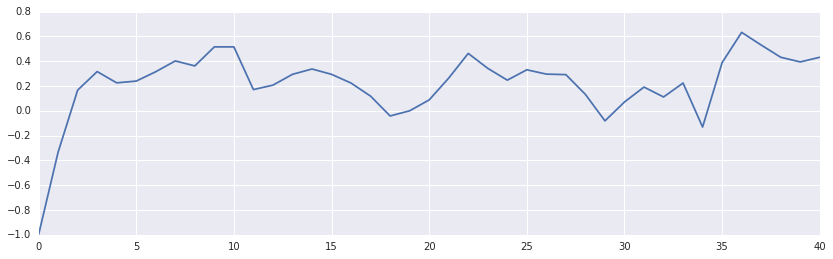

In [31]:
vs = [prediction_performance_by_date[k] for k in sorted(prediction_performance_by_date)]
plot1 = pd.Series (vs).plot(figsize=(14,4))
print ('Calidad de las predicciones de Trueskill a lo largo del tiempo')
plt.show()


In [7]:
def translate_rating (r):
    if pd.isnull(r):
        return r
    return env.expose(r)

level_history = ratings_history.apply(lambda s: [translate_rating(x) for x in s]).sort_index()


In [8]:
anchored_history = pd.DataFrame(index=range(-20, 0))
for p in level_history:
    s = level_history[[p]].dropna()
    s.index = range(-1*len(s), 0)
    anchored_history[p] = s


In [32]:
last_per_player = level_history.apply(pd.Series.last_valid_index)
leaderboard= pd.DataFrame()
leaderboard['player'] = pd.Series(last_per_player.index)
leaderboard['last_game'] = pd.Series([last_per_player[i] for i in last_per_player.index])
leaderboard['level'] = pd.Series([level_history[p][last_per_player[p]] for p in last_per_player.index], index=leaderboard.index)
leaderboard['rating'] = pd.Series([ratings_history[p][last_per_player[p]] for p in last_per_player.index], index=leaderboard.index)


leaderboard.sort_values(by='level', ascending=False, inplace=True)
leaderboard.index = range(1, len(leaderboard)+1)

print ('Tabla de posiciones')
leaderboard

Tabla de posiciones


,player,last_game,level,rating
1,NB,2016-09-13,30.401561,"trueskill.Rating(mu=35.585, sigma=1.728)"
2,DP,2016-08-30,22.702455,"trueskill.Rating(mu=30.494, sigma=2.597)"
3,RL,2016-08-22,21.956684,"trueskill.Rating(mu=27.908, sigma=1.984)"
4,MLG,2016-09-13,21.069432,"trueskill.Rating(mu=26.573, sigma=1.835)"
5,JS,2016-09-06,20.190002,"trueskill.Rating(mu=25.623, sigma=1.811)"
6,SBL,2016-08-29,19.746823,"trueskill.Rating(mu=35.106, sigma=5.120)"
7,AJ,2016-09-12,17.881118,"trueskill.Rating(mu=25.676, sigma=2.598)"
8,EC,2016-08-16,16.584682,"trueskill.Rating(mu=23.883, sigma=2.433)"
9,SBA,2016-09-13,15.331234,"trueskill.Rating(mu=21.823, sigma=2.164)"
10,RRbro,2016-06-27,15.075547,"trueskill.Rating(mu=32.822, sigma=5.915)"


In [10]:
from pandas.tseries.offsets import Week
ACTIVE_WEEKS = 3

max_date = raw_df['Fecha'].max()

active_players = list(leaderboard[leaderboard['last_game'] >= max_date-Week(ACTIVE_WEEKS)]['player'])


In [11]:
def getLeaderboardPos (p):
    df = leaderboard 
    try:
        return df[df['player'] == p].index.values[0]
    except:
        return len(players)+1

Evolución histórica de cada jugador en el ranking


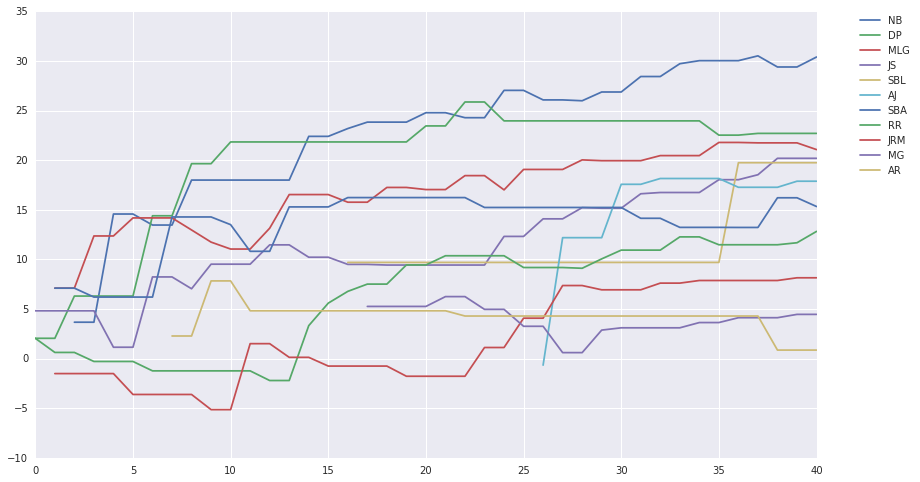

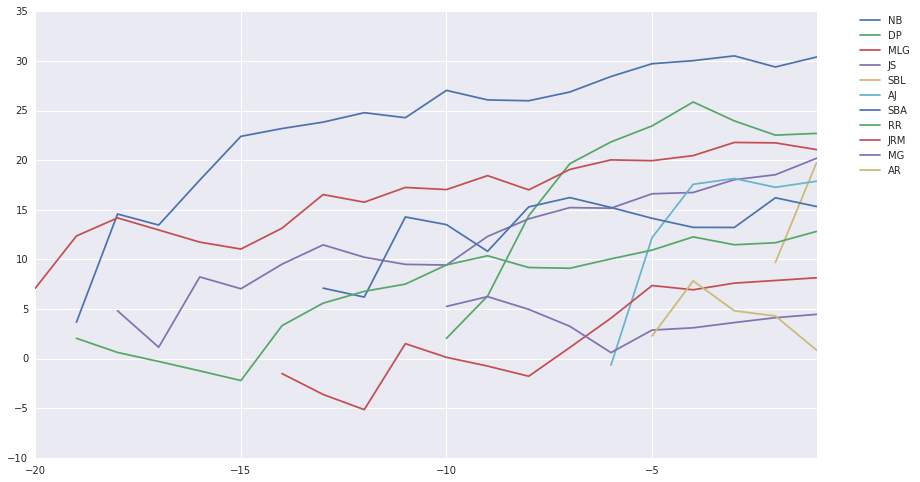

In [12]:
from collections import OrderedDict
filtered = level_history.reset_index()[active_players]

print ('Evolución histórica de cada jugador en el ranking')

filtered.fillna(method='ffill').plot(figsize=(14,8))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

filtered = anchored_history[active_players]
filtered.plot(figsize=(14,8))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()    
    


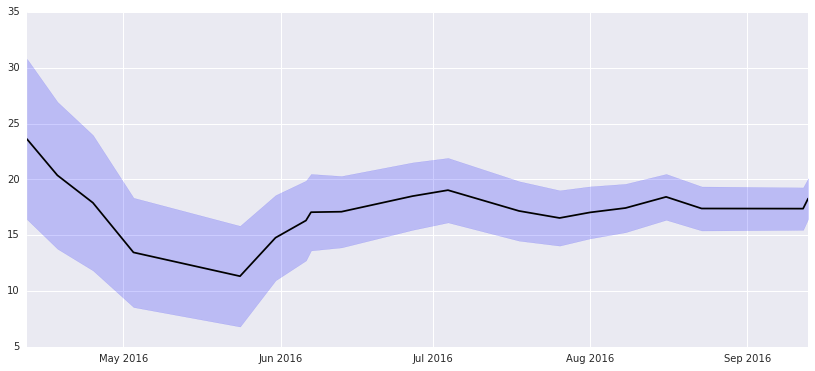

In [13]:
def display_history (Jugador):
    p = Jugador
    ra = ratings_history[p]
    ra = ra[ra.notnull()]
    
    le = level_history[p]
    le = le[le.notnull()]
    
    plt.figure(figsize=(14, 6))
    plt.plot(ra.notnull().index, [x.mu for x in ra if not pd.isnull(x)], 'k', marker='x')
    #plt.plot(le.notnull().index, [l for l in le], 'g')
    plt.fill_between(ra.index, [x.mu-x.sigma for x in ra], [x.mu+x.sigma for x in ra], color='b', alpha=0.2)

interact (display_history, Jugador=list(sorted(players.keys(), key=getLeaderboardPos)))



In [20]:
def graph2teams (team1, team2):
    from scipy.stats import norm
    import numpy as np
    x = np.linspace(-40,70,1000)
    for p in team1 + team2:
        if p in team1:
            color = 'r'
        else:
            color = 'b'
        r = players.get(p, Rating())
        y = norm.pdf(x, loc=r.mu, scale=r.sigma)
        line = plt.fill_between(x,[0 for _ in x], y, label=r'$%s\ (\mu=%0.3f\ \sigma=%0.3f)$' % (p, r.mu, r.sigma) , alpha=0.3, color=color)
        #line.figure.set_size_inches((15,8))
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()    

	Equipo 1: NB (1) y MLG (4)  Prob. de ganar: 0.8186
	Equipo 2: DP (2) y RL (3)  Prob. de ganar: 0.1814


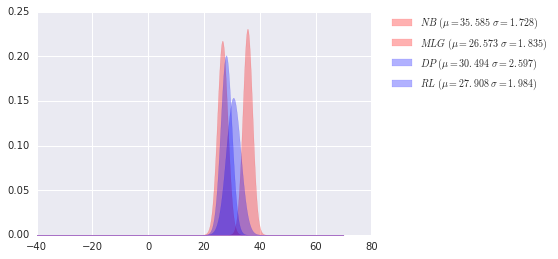

Evolución de "nivel" por Jugador (nivel=mu-3*sigma)


<function __main__.calcularMejorCruce>

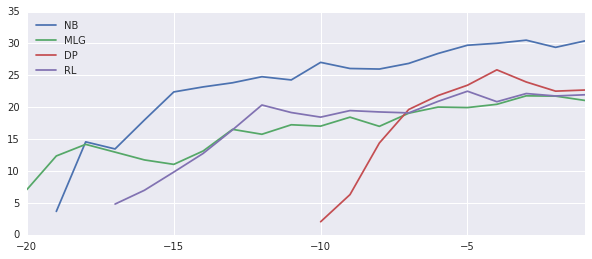

In [30]:
def calcularMejorCruce (Jugadores=''):
    selected_players = Jugadores
    if len(selected_players.split()) < 4:
        return
    
    pasados = set()
    
    best_quality = 99999
    best_match = None
    for possible in itertools.permutations (selected_players.split(' ')):
        team1, team2 = sorted(possible[:2]), sorted(possible[2:4])
        par = tuple(sorted((tuple(sorted(team1)), tuple(sorted(team2)))))
        if par in pasados:
            continue
        pasados.add(par)
        
        p1, p2 = team1
        p3, p4 = team2
        rating_group = ({p1: players.get(p1, Rating()), p2: players.get(p2, Rating())},
                        {p3: players.get(p3, Rating()), p4: players.get(p4, Rating())})
        wp = winProbability (rAlist=[players.get(team1[0], Rating()), 
                                    players.get(team1[1], Rating())],  
                            rBlist=[players.get(team2[0], Rating()), 
                                    players.get(team2[1], Rating())]) 
        if wp < 0.5:
            q = 0.5 - wp
        else:
            q = wp - 0.5
            
        #print (team1, team2, wp, q)
        if q < best_quality:
            best_quality = q
            best_match = (team1, team2)

    team1, team2 = best_match
    team1 = sorted(team1, key=getLeaderboardPos, reverse=False)
    team2 = sorted(team2, key=getLeaderboardPos, reverse=False)

    pwin = winProbability (rAlist=[players.get(team1[0], Rating()), 
                                   players.get(team1[1], Rating())],  
                           rBlist=[players.get(team2[0], Rating()), 
                                   players.get(team2[1], Rating())])

    print ('\tEquipo 1: %s (%d) y %s (%d)  Prob. de ganar: %.4f' % (team1[0], getLeaderboardPos(team1[0]), team1[1], getLeaderboardPos(team1[1]), pwin))
    print ('\tEquipo 2: %s (%d) y %s (%d)  Prob. de ganar: %.4f' % (team2[0], getLeaderboardPos(team2[0]), team2[1], getLeaderboardPos(team2[1]), 1.0-pwin))
    #print ('\n\tMatch quality: %0.4f' % best_quality)

    graph2teams (team1, team2)

    print ('Evolución de "nivel" por Jugador (nivel=mu-3*sigma)')
    
    anchored_history[[p for p in team1+team2 if p in players]].plot(figsize=(10,4))

print ("Ingresa 4 o mas iniciales de jugadores para calcular el mejor cruce de parejas")
interact (calcularMejorCruce, Jugadores=' '.join(list(leaderboard['player'][:4])), description='Jugadores disponibles')